## **Data Scraping and Preprocessing**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

years = [str(year) for year in range(2011,2024)]

teams = [
    'arizona-cardinals',
    'atlanta-falcons',
    'baltimore-ravens',
    'buffalo-bills',
    'carolina-panthers',
    'chicago-bears',
    'cincinnati-bengals',
    'cleveland-browns',
    'dallas-cowboys',
    'denver-broncos',
    'detroit-lions',
    'green-bay-packers',
    'houston-texans',
    'indianapolis-colts',
    'jacksonville-jaguars',
    'kansas-city-chiefs',
    'los-angeles-chargers',
    'los-angeles-rams',
    'las-vegas-raiders',
    'miami-dolphins',
    'minnesota-vikings',
    'new-england-patriots',
    'new-orleans-saints',
    'new-york-giants',
    'new-york-jets',
    'philadelphia-eagles',
    'pittsburgh-steelers',
    'seattle-seahawks',
    'san-francisco-49ers',
    'tampa-bay-buccaneers',
    'tennessee-titans',
    'washington-commanders'
]

urls=[]

for year in years:
  for team in teams:
    urls.append(f"https://www.spotrac.com/nfl/{team}/cap/_/year/{year}/sort/cap_total")
print(len(set(urls)), len(set(teams)))

416 32


In [5]:
!pip install backoff

In [10]:
from tqdm import tqdm
import backoff
import requests
import pandas as pd
import urllib.error
import time

def map_division(team):
  if team in ['cin', 'cle', 'pit', 'bal']:
    return 'afcn'
  elif team in ['ne', 'buf', 'nyj', 'mia']:
    return 'afce'
  elif team in ['ind', 'hou', 'ten', 'jax']:
    return 'afcs'
  elif team in ['kc', 'den', 'lac', 'lv']:
    return 'afcw'
  elif team in ['min', 'det', 'gb', 'chi']:
    return 'nfcn'
  elif team in ['phi', 'nyg', 'dal', 'was']:
    return 'nfce'
  elif team in ['car', 'atl', 'tb', 'no']:
    return 'nfcs'
  elif team in ['sf', 'sea', 'lar', 'ari']:
    return 'nfcw'
  else:
    return ''

def map_team(team):
  if team == 'arizona-cardinals':
    return 'ari'
  elif team == 'atlanta-falcons':
    return 'atl'
  elif team == 'baltimore-ravens':
    return 'bal'
  elif team == 'buffalo-bills':
    return 'buf'
  elif team == 'carolina-panthers':
    return 'car'
  elif team == 'chicago-bears':
    return 'chi'
  elif team == 'cincinnati-bengals':
    return 'cin'
  elif team == 'cleveland-browns':
    return 'cle'
  elif team == 'dallas-cowboys':
    return 'dal'
  elif team == 'denver-broncos':
    return 'den'
  elif team == 'detroit-lions':
    return 'det'
  elif team == 'green-bay-packers':
    return 'gb'
  elif team == 'houston-texans':
    return 'hou'
  elif team == 'indianapolis-colts':
    return 'ind'
  elif team == 'jacksonville-jaguars':
    return 'jax'
  elif team == 'kansas-city-chiefs':
    return 'kc'
  elif team == 'los-angeles-chargers':
    return 'lac'
  elif team == 'los-angeles-rams':
    return 'lar'
  elif team == 'las-vegas-raiders':
    return 'lv'
  elif team == 'miami-dolphins':
    return 'mia'
  elif team == 'minnesota-vikings':
    return 'min'
  elif team == 'new-england-patriots':
    return 'ne'
  elif team == 'new-orleans-saints':
    return 'no'
  elif team == 'new-york-giants':
    return 'nyg'
  elif team == 'new-york-jets':
    return 'nyj'
  elif team == 'philadelphia-eagles':
    return 'phi'
  elif team == 'pittsburgh-steelers':
    return 'pit'
  elif team == 'seattle-seahawks':
    return 'sea'
  elif team == 'san-francisco-49ers':
    return 'sf'
  elif team == 'tampa-bay-buccaneers':
    return 'tb'
  elif team == 'tennessee-titans':
    return 'ten'
  elif team == 'washington-commanders':
    return 'was'
  else:
    return ''

@backoff.on_exception(backoff.expo,
                      (urllib.error.HTTPError, urllib.error.URLError),
                      max_tries=3,  # Retry up to 3 times
                      giveup=lambda e: e.code not in [500, 502, 503, 504])
def fetch_url(url):
  """Fetches the URL with retry and error handling."""
  return pd.read_html(url)

master_df = pd.DataFrame()
for url in tqdm(urls, "Processing URLs"):
  try:
    all_tables = fetch_url(url)
    active_roster = pd.DataFrame(all_tables[0])
    injured_reserve = pd.DataFrame(all_tables[1])
    dead_money = pd.DataFrame(all_tables[len(all_tables)-2])
    all_salaries = [active_roster, injured_reserve, dead_money]
    for df in all_salaries:
      for col in df.columns:
        if 'Unnamed' in col:
          df.drop(columns=col, inplace=True)
        if 'Player' in col:
          df[col] = df[col].str.split('  ').str[1] if df[col].dtype == 'object' else df[col]
          df.rename(columns={col: 'Player'}, inplace=True)
        if 'Pct' in col:
          df[col] = df[col].str.replace('%', '').str.replace('-', '').str.replace(',', '') if df[col].dtype == 'object' else df[col]
          df[col] = pd.to_numeric(df[col])
          df[col] = df[col] / 100
          df.rename(columns={col: "Cap %"}, inplace=True)
        if col == 'Cap Hit':
          df[col] = df[col].str.replace('$', '').str.replace(',', '').str.replace('-', '') if df[col].dtype == 'object' else df[col]
          df[col] = pd.to_numeric(df[col])
        if 'Base' in col:
          df[col] = df[col].str.replace('$', '').str.replace(',', '').str.replace('-', '') if df[col].dtype == 'object' else df[col]
          df[col] = pd.to_numeric(df[col])
          df.rename(columns={col: 'Base Salary'}, inplace=True)
        if 'Bonus' in col:
          df[col] = df[col].str.replace('$', '').str.replace(',', '').str.replace('-', '') if df[col].dtype == 'object' else df[col]
          df[col] = pd.to_numeric(df[col])
        if 'Dead' in col:
          if df[col].dtype == 'object':  # Ensure it's a string column
            df[col] = df[col].str.replace('$', '').str.replace(',', '').str.replace('-', '').str.replace(')', '').str.replace('(', '')
            df[col] = df[col].apply(lambda x: 0 if isinstance(x, str) and x.startswith('(') else x)
          df[col] = pd.to_numeric(df[col])
        if 'Restructure' in col:
          df[col] = df[col].str.replace('$', '').str.replace(',', '').str.replace('-', '') if df[col].dtype == 'object' else df[col]
          df[col] = pd.to_numeric(df[col])
        if 'Likely' in col:
          df[col] = df[col].str.replace('$', '').str.replace(',', '').str.replace('-', '') if df[col].dtype == 'object' else df[col]
          df[col] = pd.to_numeric(df[col])
          df.rename(columns={col: 'Incentives'}, inplace=True)
        if 'Age' in col:
          df[col] = pd.to_numeric(df[col])
      df.fillna(0, inplace=True)
      # add column to indicate active, injured reserve, dead money
      df['roster'] = ""
      if df.equals(active_roster):
        df['roster'] = 'active'
      elif df.equals(injured_reserve):
        df['roster'] = 'ir'
      elif df.equals(dead_money):
        df['roster'] = 'dead'
      all_salaries = pd.concat([active_roster, injured_reserve, dead_money], ignore_index=True)
      all_salaries = all_salaries.rename({
          'Player': 'player',
          'Pos': 'position',
          'Age': 'age',
          'Cap Hit': 'cap_hit',
          'Cap %': 'cap_percent',
          'Dead Cap': 'dead_cap',
          'Base Salary': 'base_salary',
          'Signing Bonus  Proration': 'signing_bonus',
          'Per Game  Bonus': 'per_game_bonus',
          'Roster  Bonus': 'roster_bonus',
          'Option  Bonus': 'option_bonus',
          'Workout  Bonus': 'workout_bonus',
          'Restructure  Proration': 'restructure',
          'Restructure  Bonus': 'restructure_bonus',
          'Incentives': 'incentives'
      }, axis=1)
      # add column for year and team
      all_salaries['year'] = 0
      all_salaries['team'] = ''
      all_salaries['division'] = ''
      parts = url.split('/')
      year = int(parts[-3])
      team = map_team(parts[4])
      division = map_division(team)
      for i in range(len(all_salaries)):
        all_salaries.loc[i, 'year'] = year
        all_salaries.loc[i, 'team'] = team.upper()
        all_salaries.loc[i, 'division'] = division.upper()
      # Update 'dead_cap' based on the condition
      all_salaries.loc[all_salaries['roster'] == 'dead', 'dead_cap'] = all_salaries.loc[all_salaries['roster'] == 'dead', 'cap_hit'].astype(float)
      for col in all_salaries.select_dtypes(include='number').columns:
        if col != 'age':
          all_salaries[col] = all_salaries[col].fillna(0)
    master_df = pd.concat([master_df, all_salaries], ignore_index=True)
  except urllib.error.HTTPError as e:
    if e.code == 404:
      print(f"Skipping URL (404): {url}")
      continue
    else:
      print(f"Error fetching URL ({e.code}): {url}")
      continue  # or raise e to stop execution
  finally:
    # Add a delay after each request, regardless of success or failure
    time.sleep(2)  # Sleep for 2 seconds
master_df.to_parquet('/content/drive/MyDrive/ISA 401 Project/salaries.parquet', compression='snappy', index=False)
master_df.to_csv('/content/drive/MyDrive/ISA 401 Project/salaries.csv', index=False)
master_df.info()

Processing URLs:  81%|████████▏ | 338/416 [17:42<04:07,  3.17s/it]INFO:backoff:Backing off fetch_url(...) for 0.9s (urllib.error.HTTPError: HTTP Error 500: Internal Server Error)
INFO:backoff:Backing off fetch_url(...) for 0.9s (urllib.error.HTTPError: HTTP Error 500: Internal Server Error)
ERROR:backoff:Giving up fetch_url(...) after 3 tries (urllib.error.HTTPError: HTTP Error 500: Internal Server Error)


Error fetching URL (500): https://www.spotrac.com/nfl/las-vegas-raiders/cap/_/year/2021/sort/cap_total


Processing URLs:  98%|█████████▊| 408/416 [21:27<00:25,  3.14s/it]INFO:backoff:Backing off fetch_url(...) for 1.0s (urllib.error.HTTPError: HTTP Error 500: Internal Server Error)
INFO:backoff:Backing off fetch_url(...) for 1.6s (urllib.error.HTTPError: HTTP Error 500: Internal Server Error)
ERROR:backoff:Giving up fetch_url(...) after 3 tries (urllib.error.HTTPError: HTTP Error 500: Internal Server Error)


Error fetching URL (500): https://www.spotrac.com/nfl/new-york-jets/cap/_/year/2023/sort/cap_total


Processing URLs: 100%|██████████| 416/416 [21:55<00:00,  3.16s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51054 entries, 0 to 51053
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   player          51054 non-null  object 
 1   position        51054 non-null  object 
 2   age             26383 non-null  float64
 3   cap_hit         51054 non-null  float64
 4   cap_percent     51054 non-null  float64
 5   dead_cap        51054 non-null  float64
 6   base_salary     51054 non-null  float64
 7   signing_bonus   51054 non-null  float64
 8   per_game_bonus  51054 non-null  float64
 9   roster_bonus    51054 non-null  float64
 10  option_bonus    51054 non-null  float64
 11  workout_bonus   51054 non-null  float64
 12  restructure     51054 non-null  float64
 13  incentives      51054 non-null  float64
 14  roster          51054 non-null  object 
 15  year            51054 non-null  int64  
 16  team            51054 non-null  object 
 17  division        51054 non-null 

## **Data Visualization**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/content/drive/MyDrive/ISA 401 Project/salaries.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51350 entries, 0 to 51349
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   player          51350 non-null  object 
 1   position        51350 non-null  object 
 2   age             26519 non-null  float64
 3   cap_hit         51350 non-null  float64
 4   cap_percent     51350 non-null  float64
 5   dead_cap        51350 non-null  float64
 6   base_salary     51350 non-null  float64
 7   signing_bonus   51350 non-null  float64
 8   per_game_bonus  51350 non-null  float64
 9   roster_bonus    51350 non-null  float64
 10  option_bonus    51350 non-null  float64
 11  workout_bonus   51350 non-null  float64
 12  restructure     51350 non-null  float64
 13  incentives      51350 non-null  float64
 14  roster          51350 non-null  object 
 15  year            51350 non-null  int64  
 16  team            51350 non-null  object 
 17  division        49851 non-null 

In [5]:
# Summarize total dead cap spending by year and team
dead_cap_summary = df.groupby(['year', 'team']).agg(
    total_dead_cap=('dead_cap', 'sum'),
    top_dead_player=('player', lambda x: x.iloc[0]),
    max_dead_cap=('dead_cap', 'max')
).reset_index()

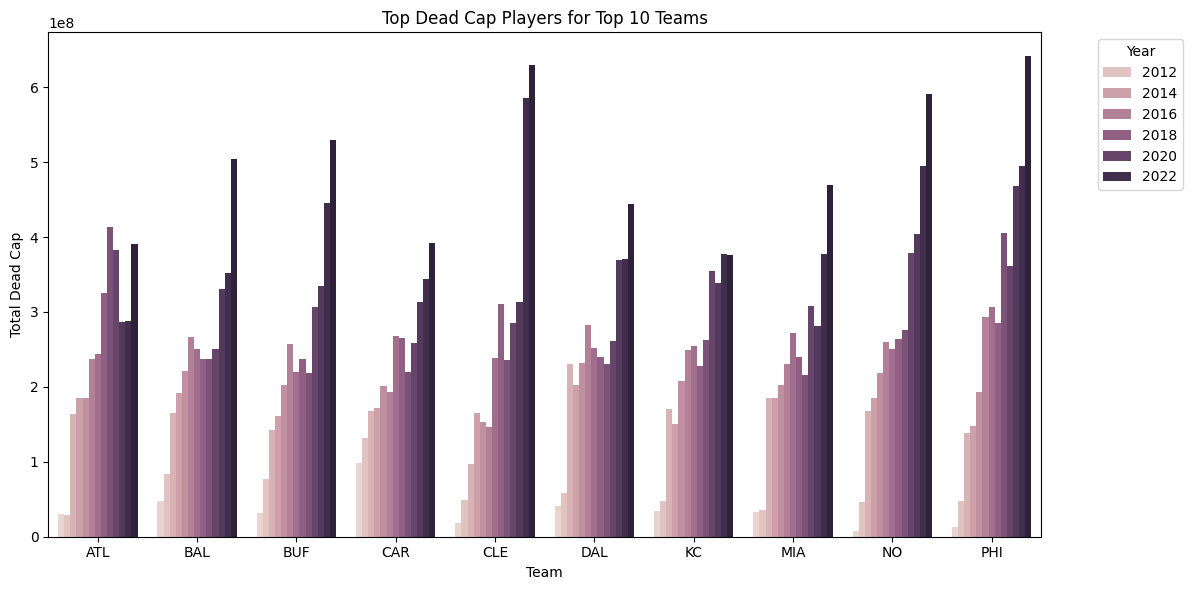

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the top 3 teams by total dead cap spending
top_teams = dead_cap_summary.groupby('team')['total_dead_cap'].sum().nlargest(10).index

# Filter for top teams
top_teams_data = dead_cap_summary[dead_cap_summary['team'].isin(top_teams)]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_teams_data, x='team', y='total_dead_cap', hue='year', dodge=True)
plt.title('Top Dead Cap Players for Top 10 Teams')
plt.xlabel('Team')
plt.ylabel('Total Dead Cap')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

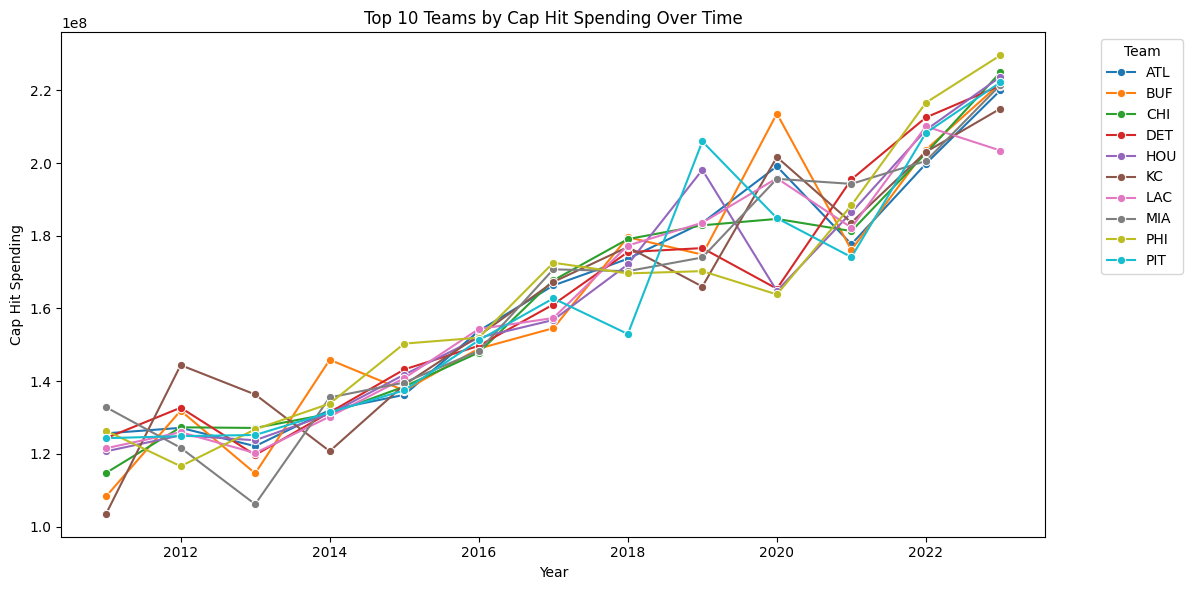

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
file_path = '/content/drive/MyDrive/ISA 401 Project/salaries.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Group by team and year, and calculate total cap hit
team_cap_hit = data.groupby(['year', 'team'])['cap_hit'].sum().reset_index()

# Identify the top 10 teams by overall cap hit spending across all years
top_10_teams = team_cap_hit.groupby('team')['cap_hit'].sum().nlargest(10).index

# Filter the dataset to include only the top 10 teams
top_10_teams_data = team_cap_hit[team_cap_hit['team'].isin(top_10_teams)]

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_10_teams_data, x='year', y='cap_hit', hue='team', marker='o')
plt.title('Top 10 Teams by Cap Hit Spending Over Time')
plt.xlabel('Year')
plt.ylabel('Cap Hit Spending')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

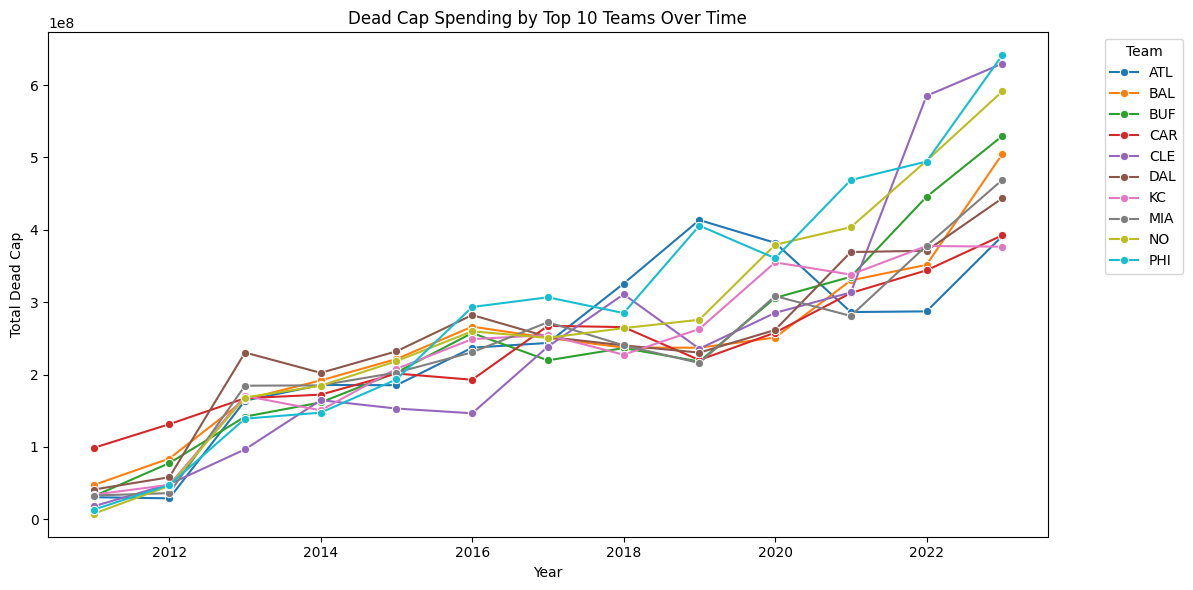

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

total_dead_cap_by_team = df.groupby('team')['dead_cap'].sum().nlargest(10).index

# Filter data to include only the top 10 teams
top_10_teams_data = df[df['team'].isin(total_dead_cap_by_team)]

dead_cap_summary = top_10_teams_data.groupby(['year', 'team'])['dead_cap'].sum().reset_index()


# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=dead_cap_summary, x='year', y='dead_cap', hue='team', marker='o')
plt.title('Dead Cap Spending by Top 10 Teams Over Time')
plt.xlabel('Year')
plt.ylabel('Total Dead Cap')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

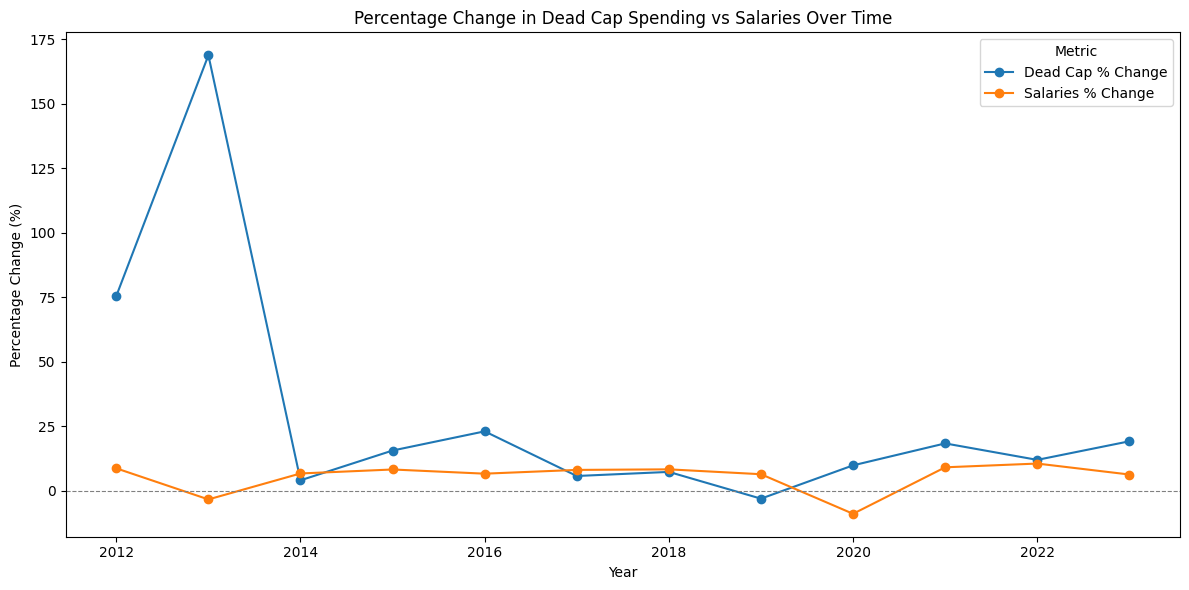

In [9]:
# Group by year and calculate total dead cap and total salaries
yearly_totals = df.groupby('year').agg(
    total_dead_cap=('dead_cap', 'sum'),
    total_salaries=('cap_hit', 'sum')
).reset_index()

# Calculate the annual percentage change for dead cap and salaries
yearly_totals['dead_cap_pct_change'] = yearly_totals['total_dead_cap'].pct_change() * 100
yearly_totals['salaries_pct_change'] = yearly_totals['total_salaries'].pct_change() * 100

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot percentage change in dead cap
plt.plot(yearly_totals['year'], yearly_totals['dead_cap_pct_change'], marker='o', label='Dead Cap % Change')

# Plot percentage change in salaries
plt.plot(yearly_totals['year'], yearly_totals['salaries_pct_change'], marker='o', label='Salaries % Change')

# Add titles and labels
plt.title('Percentage Change in Dead Cap Spending vs Salaries Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage Change (%)')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

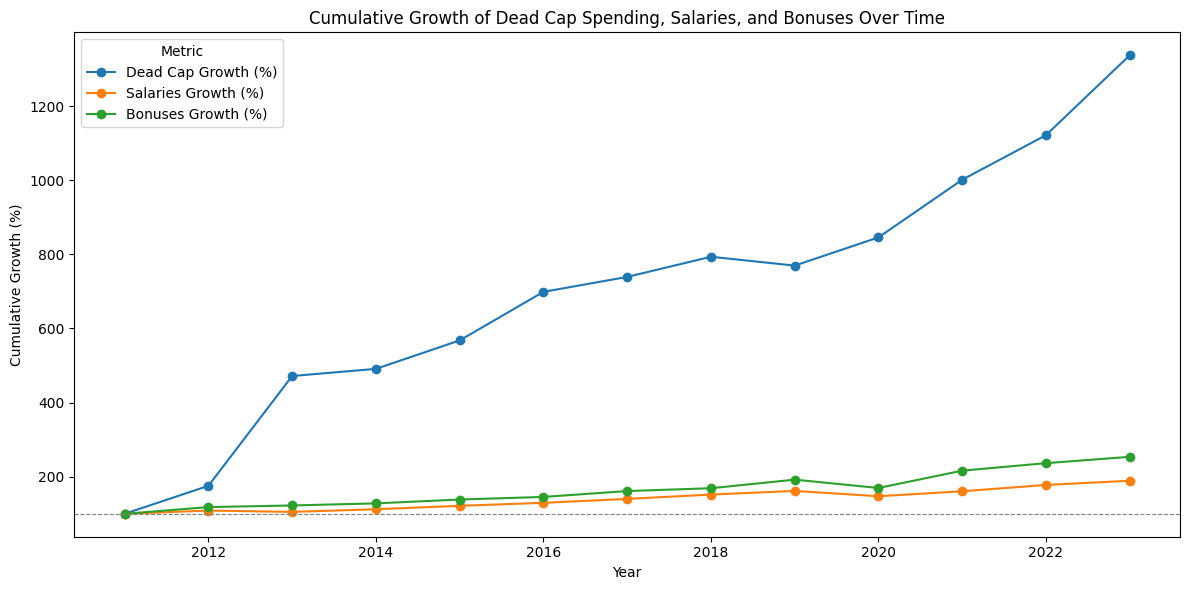

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is already loaded into 'data'
# Group by year and calculate totals for dead cap, salaries, and bonuses
yearly_totals = data.groupby('year').agg(
    total_dead_cap=('dead_cap', 'sum'),
    total_salaries=('cap_hit', 'sum'),
    total_bonuses=('signing_bonus', 'sum')  # Assuming 'signing_bonus' column exists
).reset_index()

# Calculate cumulative growth for dead cap, salaries, and bonuses
yearly_totals['dead_cap_growth'] = (yearly_totals['total_dead_cap'] / yearly_totals['total_dead_cap'].iloc[0]) * 100
yearly_totals['salaries_growth'] = (yearly_totals['total_salaries'] / yearly_totals['total_salaries'].iloc[0]) * 100
yearly_totals['bonuses_growth'] = (yearly_totals['total_bonuses'] / yearly_totals['total_bonuses'].iloc[0]) * 100

# Plot cumulative growth
plt.figure(figsize=(12, 6))

# Plot cumulative growth for dead cap
plt.plot(yearly_totals['year'], yearly_totals['dead_cap_growth'], marker='o', label='Dead Cap Growth (%)')

# Plot cumulative growth for salaries
plt.plot(yearly_totals['year'], yearly_totals['salaries_growth'], marker='o', label='Salaries Growth (%)')

# Plot cumulative growth for bonuses
plt.plot(yearly_totals['year'], yearly_totals['bonuses_growth'], marker='o', label='Bonuses Growth (%)')

# Add titles and labels
plt.title('Cumulative Growth of Dead Cap Spending, Salaries, and Bonuses Over Time')
plt.xlabel('Year')
plt.ylabel('Cumulative Growth (%)')
plt.axhline(100, color='grey', linestyle='--', linewidth=0.8)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

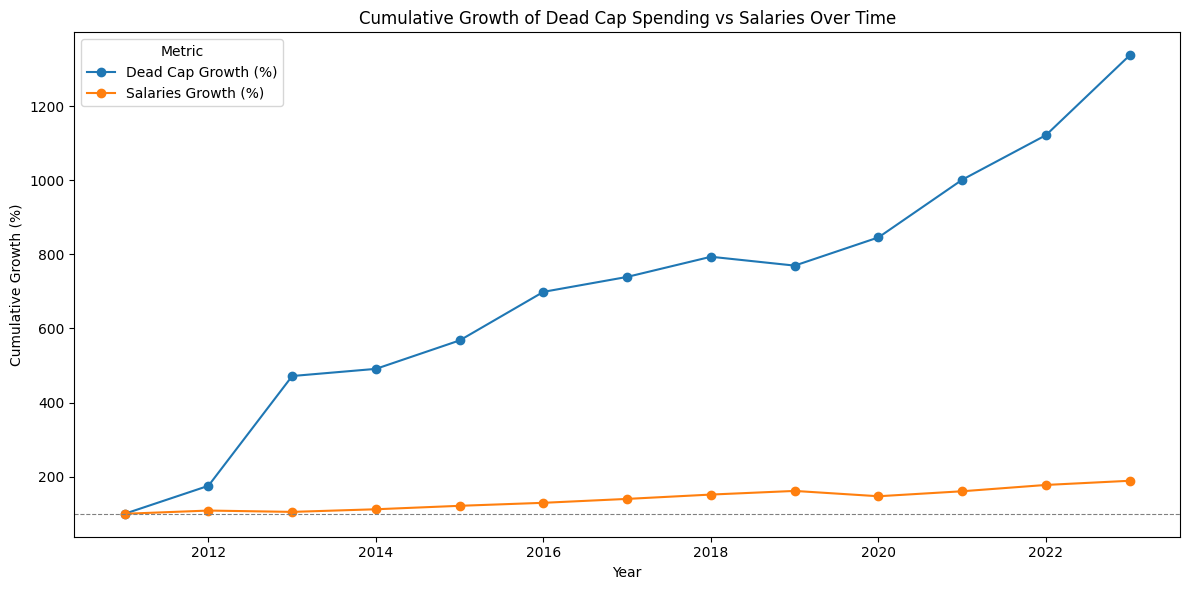

In [11]:
yearly_totals['dead_cap_growth'] = (yearly_totals['total_dead_cap'] / yearly_totals['total_dead_cap'].iloc[0]) * 100
yearly_totals['salaries_growth'] = (yearly_totals['total_salaries'] / yearly_totals['total_salaries'].iloc[0]) * 100

plt.figure(figsize=(12, 6))

# Plot cumulative growth for dead cap
plt.plot(yearly_totals['year'], yearly_totals['dead_cap_growth'], marker='o', label='Dead Cap Growth (%)')

# Plot cumulative growth for salaries
plt.plot(yearly_totals['year'], yearly_totals['salaries_growth'], marker='o', label='Salaries Growth (%)')

# Add titles and labels
plt.title('Cumulative Growth of Dead Cap Spending vs Salaries Over Time')
plt.xlabel('Year')
plt.ylabel('Cumulative Growth (%)')
plt.axhline(100, color='grey', linestyle='--', linewidth=0.8)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

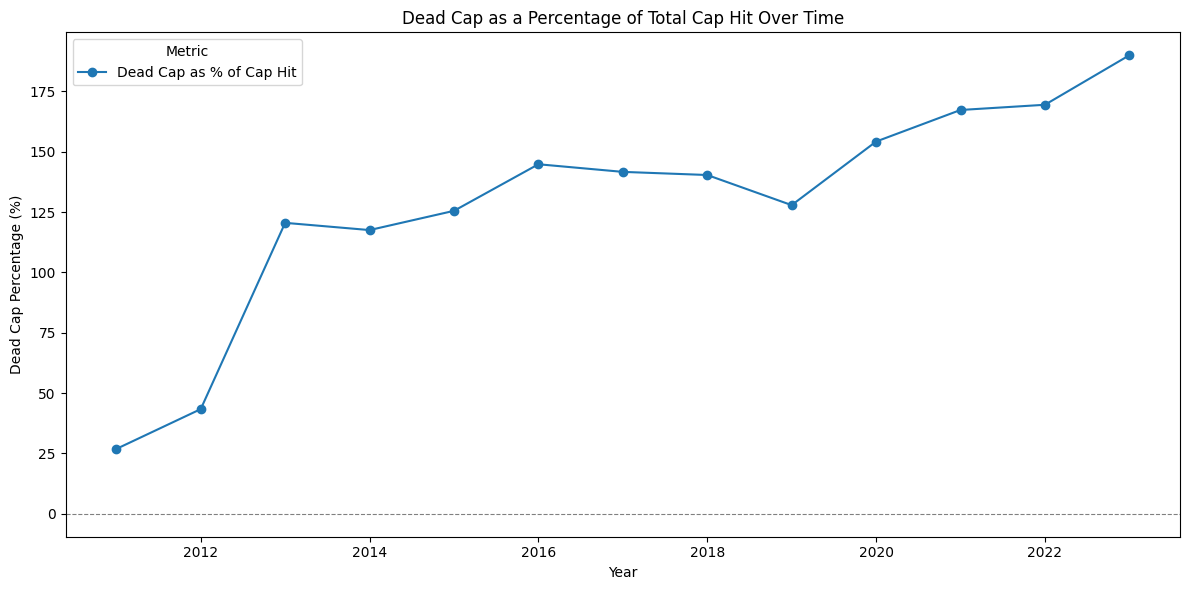

In [12]:
# Calculate total dead cap and cap hit by year
dead_cap_percentage = data.groupby('year').agg(
    total_dead_cap=('dead_cap', 'sum'),
    total_cap_hit=('cap_hit', 'sum')
).reset_index()

# Calculate dead cap as a percentage of total cap hit
dead_cap_percentage['dead_cap_percent'] = (dead_cap_percentage['total_dead_cap'] / dead_cap_percentage['total_cap_hit']) * 100

# Plot the percentage over time
plt.figure(figsize=(12, 6))
plt.plot(dead_cap_percentage['year'], dead_cap_percentage['dead_cap_percent'], marker='o', label='Dead Cap as % of Cap Hit')

# Add titles and labels
plt.title('Dead Cap as a Percentage of Total Cap Hit Over Time')
plt.xlabel('Year')
plt.ylabel('Dead Cap Percentage (%)')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

<ipython-input-18-26a9beab3664>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cap_hit', y='team', data=data_2023, orient='h', palette='Set3')


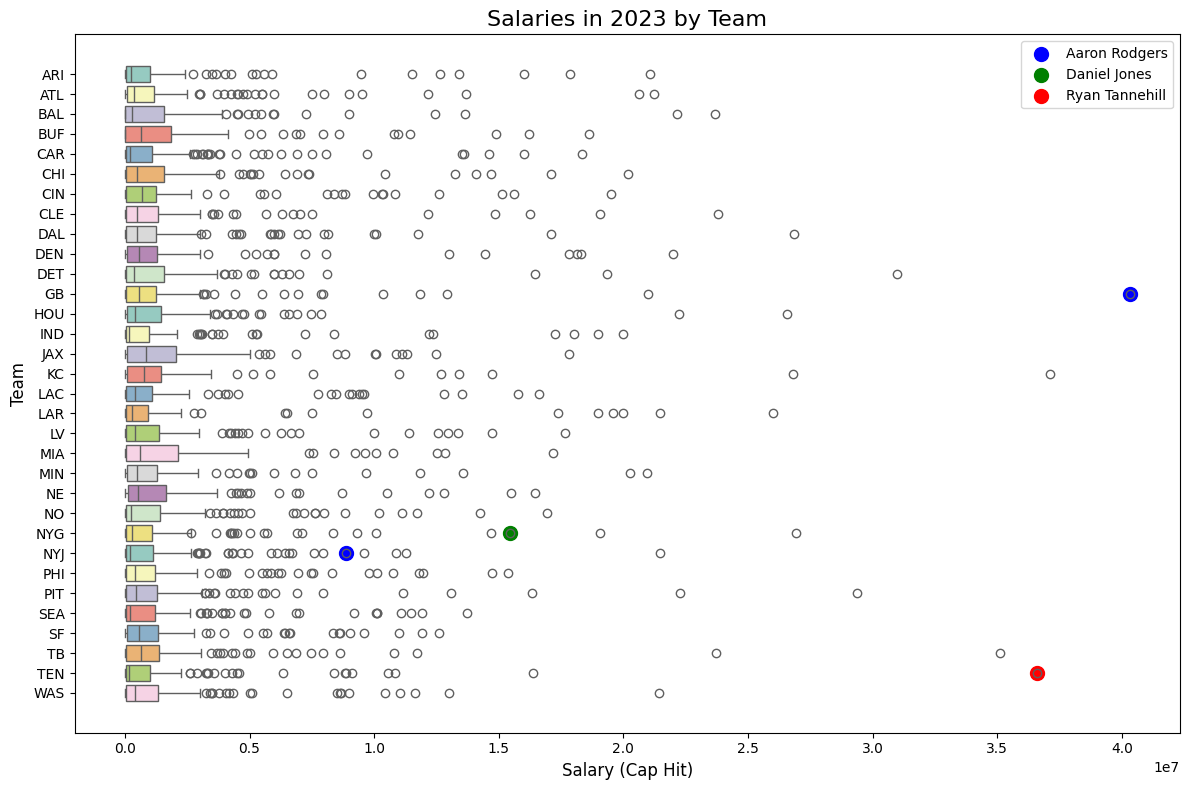

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
file_path = '/content/drive/MyDrive/ISA 401 Project/salaries.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Filter data for the year 2023
data_2023 = data[data['year'] == 2023]

# Find data for Ryan Tannehill, Aaron Rodgers, and Daniel Jones
highlight_players = ['Ryan Tannehill', 'Aaron Rodgers', 'Daniel Jones']
highlight_data = data_2023[data_2023['player'].isin(highlight_players)]

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='cap_hit', y='team', data=data_2023, orient='h', palette='Set3')

# Define colors for each player
player_colors = {
    'Ryan Tannehill': 'red',
    'Aaron Rodgers': 'blue',
    'Daniel Jones': 'green'
}

# Highlight players
for _, player_row in highlight_data.iterrows():
    plt.scatter(
        player_row['cap_hit'],
        player_row['team'],
        color=player_colors[player_row['player']],  # Assign color based on player
        s=100,  # Size of the marker
        label=player_row['player'] if player_row['player'] not in plt.gca().get_legend_handles_labels()[1] else None
    )

# Add titles and labels
plt.title('Salaries in 2023 by Team', fontsize=16)
plt.xlabel('Salary (Cap Hit)', fontsize=12)
plt.ylabel('Team', fontsize=12)

# Add a legend
if not highlight_data.empty:
    plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()